# Bearings NASA Anomaly Detection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from sklearn.ensemble import IsolationForest

# Dataset Description

Vibration sensor readings from NASA Acoustics and Vibration Database. sensor readings were taken on four bearings that were run to failure under constant load and running conditions. The vibration measurement signals are provided for the datasets over the lifetime of the bearings until failure. Failure occurred after 100 million cycles with a crack in the outer race.

# Data Preprocessing

In [ ]:
# read dataset
df = pd.read_csv('/content/drive/MyDrive/BearingVibration_Dataset.csv')

In [ ]:
# dataset preview
df.head()

,Unnamed: 0,Bearing 1,Bearing 2,Bearing 3,Bearing 4
0,2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
1,2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2,2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
3,2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
4,2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


Unnamed: 0 should be the datetime and it moves 10 per minutes

In [ ]:
# get dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  982 non-null    object 
 1   Bearing 1   982 non-null    float64
 2   Bearing 2   982 non-null    float64
 3   Bearing 3   982 non-null    float64
 4   Bearing 4   982 non-null    float64
dtypes: float64(4), object(1)
memory usage: 38.5+ KB


Dataset shape : (982,5)

Null value : None

Wrong datatypes : Unnamed: 0

In [ ]:
# check duplicated value
df.duplicated().sum()

0

Duplicated value : None

In [ ]:
# rename unnamed: 0
df = df.rename(columns={'Unnamed: 0':'Date'})

In [ ]:
# object to datetime Date
df['Date'] = pd.to_datetime(df['Date'])

# Exploratory Data Analysis

In [ ]:
# melt dataframe for chart
df0 = pd.melt(df, id_vars='Date', var_name="Bearing", value_name="Vibration")

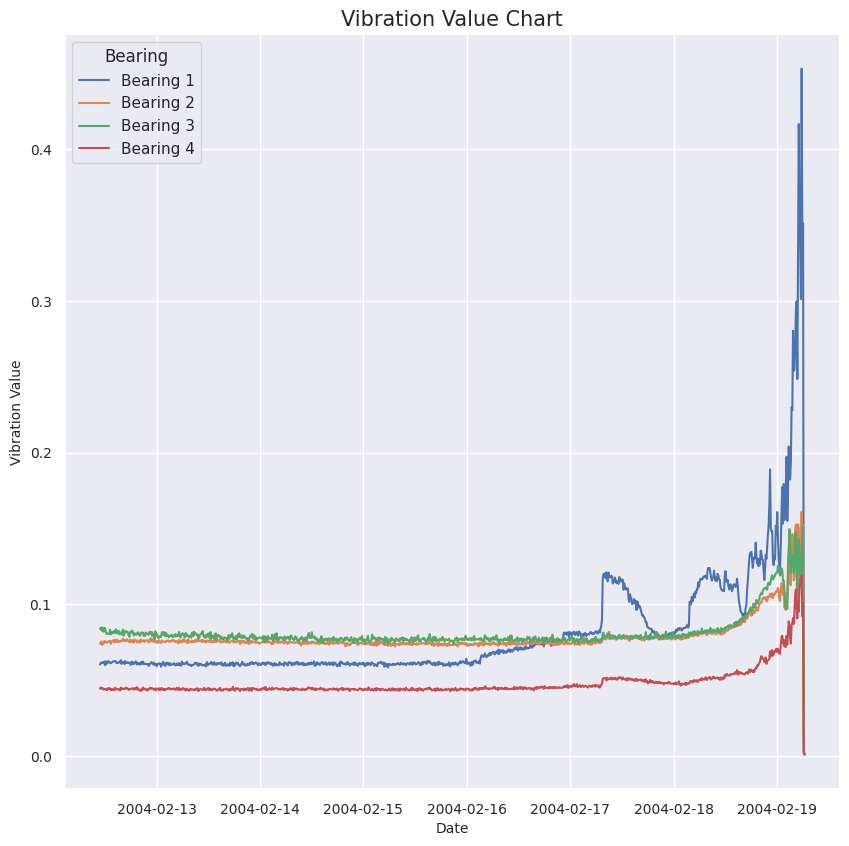

In [ ]:
sns.set()
fig = plt.figure(figsize =(10, 10),dpi=100)
colors = sns.color_palette('pastel')[0]
ax = sns.lineplot(data=df0, x="Date", y="Vibration", hue='Bearing')
ax.axes.set_title("Vibration Value Chart",fontsize=15)
ax.set_xlabel("Date",fontsize=10)
ax.set_ylabel("Vibration Value",fontsize=10)
ax.tick_params(labelsize=10)
plt.show()

Analysis result based on graph:

1. Bearing 1, 2, 3, and 4 have a different vibration value distribution
2. Bearing 1 vibration value start increase significantly from date 2004-02-16
3. Bearing 2, 3, 4 vibration value start to increase significantly from date 2004-02-18, about two day after Bearing 1 value is increasing


# Modelling

I will use the unsupervised method called Isolation Forest to determine the anomalies

Assumption:

1. Each Bearing has a differrent standard value and it will never change
2. Bearing 1, 2, 3, 4 is a part of a system 

In [ ]:
# define and fit model
model=IsolationForest(n_estimators=500,max_samples='auto',contamination='auto')
model.fit(df[['Bearing 1','Bearing 2','Bearing 3','Bearing 4']])

IsolationForest(n_estimators=500)

In [ ]:
# predict and show the result
df['scores'] = model.decision_function(df[['Bearing 1','Bearing 2','Bearing 3','Bearing 4']])

df['anomaly_score'] = model.predict(df[['Bearing 1','Bearing 2','Bearing 3','Bearing 4']])

df[df['anomaly_score']==-1].head()

,Date,Bearing 1,Bearing 2,Bearing 3,Bearing 4,scores,anomaly_score
876,2004-02-18 12:52:39,0.109866,0.084053,0.084666,0.053132,-0.001307,-1
877,2004-02-18 13:02:39,0.111518,0.084176,0.085785,0.053071,-0.000526,-1
878,2004-02-18 13:12:39,0.113188,0.084210,0.086553,0.053924,-0.003207,-1
879,2004-02-18 13:22:39,0.110351,0.084032,0.085572,0.053692,-0.001641,-1
880,2004-02-18 13:32:39,0.108665,0.085231,0.085306,0.053982,-0.011342,-1


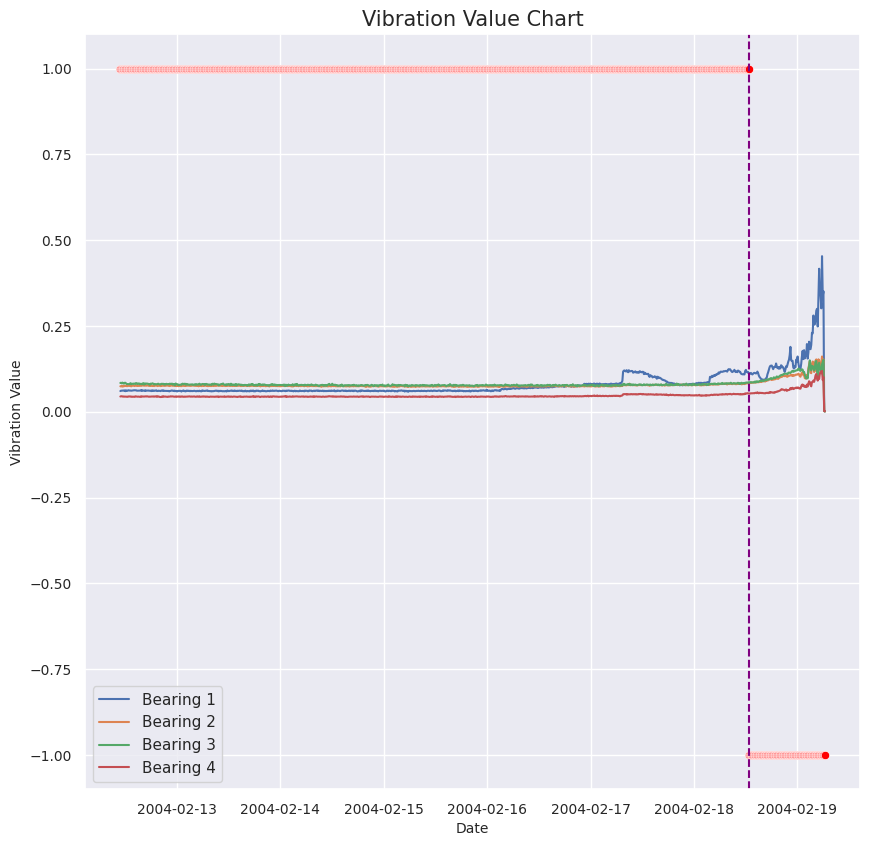

In [ ]:
# anomaly result
sns.set()
left = '2004-02-11'
right = '2004-02-20'
fig = plt.figure(figsize =(10, 10),dpi=100)
ax = sns.lineplot(data=df0[df0['Date'].between(left,right)], x="Date", y="Vibration", hue='Bearing')
sns.scatterplot(data=df[df['Date'].between(left,right)], x="Date", y="anomaly_score", color='red')
ax.axvline(df['Date'][df['anomaly_score']==-1].head(1), ls='--', c='purple')
ax.axes.set_title("Vibration Value Chart",fontsize=15)
ax.set_xlabel("Date",fontsize=10)
ax.set_ylabel("Vibration Value",fontsize=10)
ax.tick_params(labelsize=10)
plt.show()

The result is, red line in top means the data from 2004-02-13 until 2004-02-18 12:52:39 is labeled as normal and the red line in bottom means the data 2004-02-18 12:52:39  until the end is labeled as anomaly.

And I think this result is good because start from 2004-02-18 12:52:39, all Bearing vibration value start to increase significantly and lead to failure.

So with this model I can create an alarm in case of a continuous anomaly happening in the future and prevent the system failure.